# **Import & Install Library**

In [2]:
import numpy as np
import cv2
import tensorflow as tf

print("numpy", np.__version__)
print("cv2", cv2.__version__)
print("tensorflow", tf.__version__)

numpy 1.24.4
cv2 4.5.5
tensorflow 2.10.1


In [3]:
import sys
import tensorflow as tf
import pandas as pd
import sklearn as sk

check_gpu = len(tf.config.list_physical_devices('GPU')) > 0

print(f"TensorFlow Version: {tf.__version__}")
print(f"Keras Version: {tf.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print("GPU is", "available" if check_gpu else "NOT AVAILABLE")

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)]
        )
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

    # Print GPU name
    for gpu in gpus:
        gpu_details = tf.config.experimental.get_device_details(gpu)
        print("GPU Name:", gpu_details.get('device_name', 'Unknown'))


TensorFlow Version: 2.10.1
Keras Version: 2.10.0

Python 3.8.19 (default, Mar 20 2024, 19:55:45) [MSC v.1916 64 bit (AMD64)]
Pandas 2.0.3
Scikit-Learn 1.3.2
GPU is available
Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPUs
GPU Name: NVIDIA GeForce RTX 4070 SUPER


In [4]:
#Import library preprocessing
import time
import random as rd
import zipfile, os # Library untuk mendownload zipfile
from tqdm import tqdm # Sebagai pemanis visual saat mengimport gambar ke dalam array list
import numpy as np  # Library untuk mengubah gambar menjadi array
import tensorflow as tf # Library Tensorflow
from tensorflow.keras.optimizers import RMSprop # Mengimport optimizer untuk model
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Library untuk Augmentasi gambar
from tensorflow.keras import regularizers # Library untuk mencegah overfitting pada model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint # Mengimport learningrate dan model checkpoint
from sklearn.preprocessing import LabelEncoder # Untuk mengubah index menjadi string label
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical # Untuk melabeli gambar
import numpy
import cv2 # Mengimport gambar

#Import library visualisasi
import matplotlib.image as mpimg  # Library untuk visualisai gambar dengan plot
import matplotlib.pyplot as plt # Library untuk visualisai plot
%matplotlib inline
import seaborn as sns # Library untuk visualisai plot lebih bagus

from sklearn.metrics import confusion_matrix, classification_report # Untuk evaluasi model

# **Import Dataset**

Memasukkan dataset ke dalam path

In [7]:
# Dataset Path

input_dataset_path = "D:/Dataset Bangkit/bangkit_program/dataset_rusak_berat_sedang_tidak_rusak"
output_dataset_path = "D:/Dataset Bangkit/bangkit_program/split_dataset_building"

Folder input yang telah terdownload akan terlihat seperti ini:

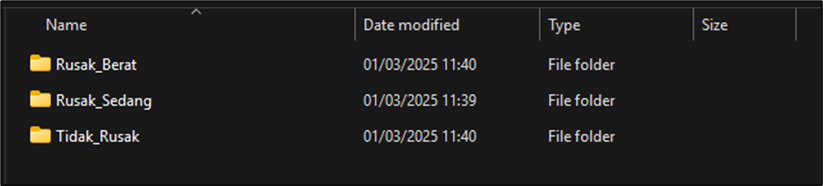

# **Data Preprocessing**

In [10]:
# Memakai library split_folders untuk membagi data train dan validasi
import splitfolders

# Membagi data train dan validasi dengan perbandingan 90% : 10% : 10%
splitfolders.ratio(
    input_dataset_path,
    output=output_dataset_path,
    seed=43,
    ratio=(.8, .1, .1)
)

Copying files: 10744 files [01:54, 94.17 files/s] 


In [11]:
# Menentukan path data train dan validasi
path = "D:/Dataset Bangkit/bangkit_program/split_dataset_building/"

train_dir = path + "train/" 
validation_dir = path + "val/"
test_dir = path + "test/"

In [12]:
print(train_dir)
print(validation_dir)
print(test_dir)

D:/Dataset Bangkit/bangkit_program/split_dataset_building/train/
D:/Dataset Bangkit/bangkit_program/split_dataset_building/val/
D:/Dataset Bangkit/bangkit_program/split_dataset_building/test/


## Augmentasi

Melakukan Augmentasi gambar untuk menciptakan data/gambar baru dari data yang telah ada

In [15]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    shear_range = 0.2,
    zoom_range = 0.1, # mengubah zoom image 
    width_shift_range=0.1,  # mengubah image secara horizontal
    height_shift_range=0.1, # mengubah image secara vertikal
    brightness_range=[0.8, 1.2],
    fill_mode='nearest',
)   
 
test_datagen = ImageDataGenerator(rescale=1./255)
                   

In [16]:
batch_size = 16
train_generator = train_datagen.flow_from_directory(
        train_dir,  # direktori data latih
        target_size=(100, 100),  # mengubah resolusi seluruh gambar menjadi 100x100 piksel
        batch_size=batch_size,
        class_mode='categorical' # karena ini merupakan masalah klasifikasi dari 3 kelas maka menggunakan class_mode = 'categorical'
) 
 
validation_generator = test_datagen.flow_from_directory(
        validation_dir, # direktori data validasi
        target_size=(100, 100), # mengubah resolusi seluruh gambar menjadi 100x100 piksel
        batch_size=batch_size,
        shuffle= False,
        class_mode='categorical' # karena ini merupakan masalah klasifikasi dari 3 kelas maka menggunakan class_mode = 'categorical'
) 

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(100,100),
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical',
)

Found 8570 images belonging to 3 classes.
Found 1071 images belonging to 3 classes.
Found 1071 images belonging to 3 classes.


### Hasil Proses Augmentasi

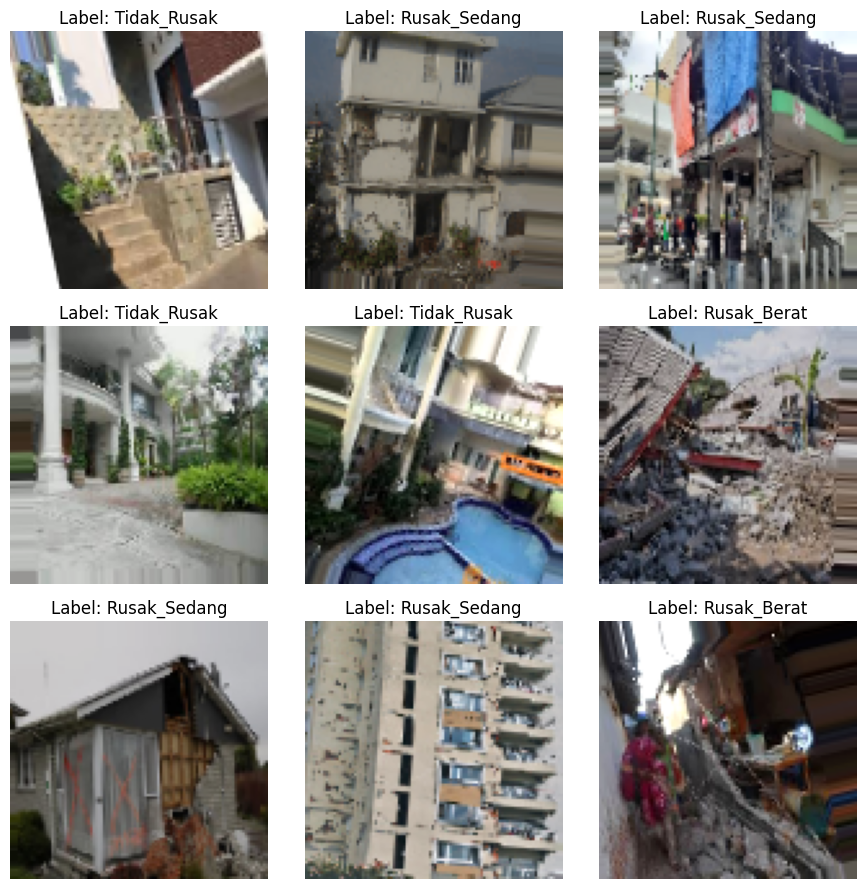

In [18]:
def show_augmented_images(data_generator, class_indices, batch_size=16, rows=3, cols=3):
    # Ambil 1 batch dari generator (otomatis teraugmentasi)
    images_batch, labels_batch = next(data_generator)

    # Mapping index → label
    index_to_label = {v: k for k, v in class_indices.items()}
    label_indices = labels_batch.argmax(axis=1)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))

    for i, ax in enumerate(axes.flatten()):
        if i >= len(images_batch):
            break
        ax.imshow(images_batch[i])
        label = index_to_label[label_indices[i]]
        ax.set_title(f'Label: {label}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

show_augmented_images(train_generator, train_generator.class_indices)

## Menampilkan Gambar Validasi Acak

In [20]:
def show_random_images_from_generator(data_generator, class_indices, rows=3, cols=3):
    # Dapatkan semua label index ke nama
    index_to_label = {v: k for k, v in class_indices.items()}

    # Ambil seluruh batch dari generator
    images = []
    labels = []

    for i in range(len(data_generator)):
        batch_images, batch_labels = data_generator[i]
        images.extend(batch_images)
        labels.extend(np.argmax(batch_labels, axis=1))  # ambil index label

    images = np.array(images)
    labels = np.array(labels)

    # Acak indeks
    total_samples = len(images)
    random_indices = np.random.choice(total_samples, rows * cols, replace=False)

    # Plot
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))

    for i, ax in enumerate(axes.flatten()):
        idx = random_indices[i]
        ax.imshow(images[idx])
        ax.set_title(f"Kelas: {index_to_label[labels[idx]]}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

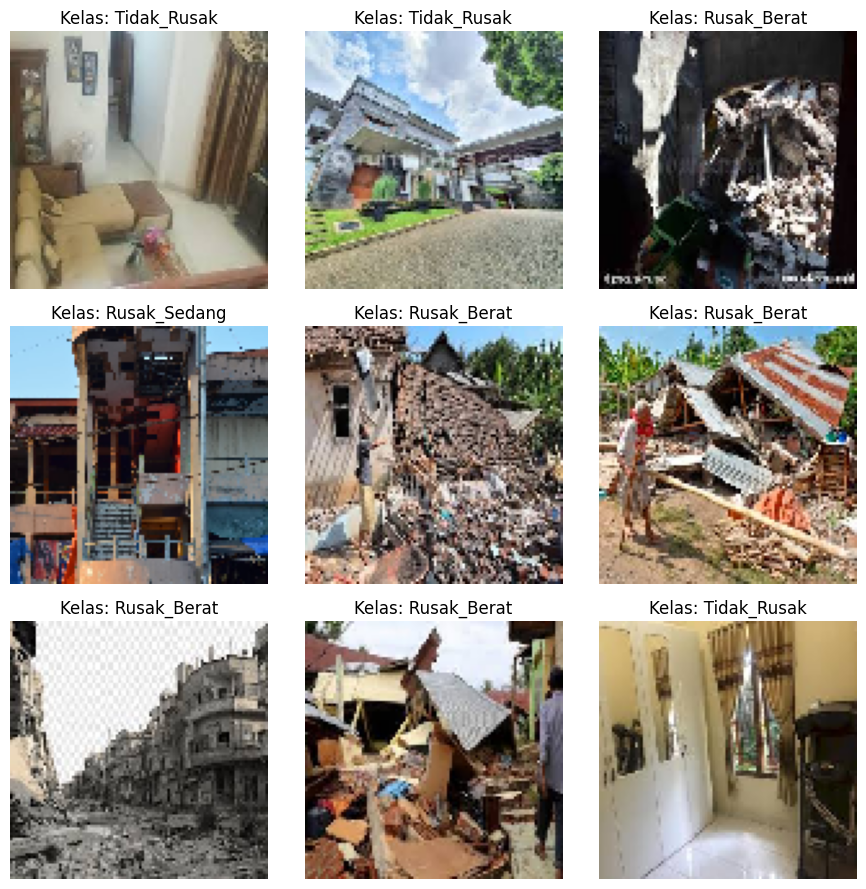

In [21]:
show_random_images_from_generator(validation_generator, validation_generator.class_indices)

# **Modelling**

In [23]:
def get_callbacks(model_filename: str, target_val_accuracy: float):
    # Buat direktori penyimpanan jika belum ada
    save_dir = os.path.join(os.getcwd(), 'saved_model')
    os.makedirs(save_dir, exist_ok=True)

    # Path lengkap untuk menyimpan model
    model_path = os.path.join(save_dir, model_filename)

    # Callback checkpoint untuk menyimpan bobot terbaik
    checkpoint_callback = ModelCheckpoint(
        filepath=model_path,
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        save_weights_only=True,
        mode='max'  # Karena kita ingin mencari val_accuracy tertinggi
    )

    # Callback custom untuk early stopping berdasarkan target akurasi
    class EarlyStopOnAccuracy(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            logs = logs or {}
            val_acc = logs.get('val_accuracy')
            if val_acc is not None and val_acc >= target_val_accuracy:
                print(f"\n✅ Akurasi validasi telah mencapai {val_acc:.3f} (>{target_val_accuracy:.3f}). Training dihentikan.")
                self.model.stop_training = True

    early_stop_callback = EarlyStopOnAccuracy()

    # Return semua callback dalam list
    return [checkpoint_callback, early_stop_callback]

In [24]:
callbacks = get_callbacks("cnn_bangunan_weights.h5", target_val_accuracy=0.885)

In [25]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu', input_shape=(100, 100, 3)),
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256,
        activation='relu',
        kernel_regularizer=regularizers.l2(0.016),
        activity_regularizer=regularizers.l1(0.006),
        bias_regularizer=regularizers.l1(0.006)
    ),
    tf.keras.layers.Dropout(0.5, seed=123),
    tf.keras.layers.Dense(3, activation='softmax')  # 3 kelas output
])

# Compile Model
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 64)        51264     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 64)       0         
 2D)                                                    

In [26]:
# Hitung steps per epoch otomatis
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = validation_generator.samples // validation_generator.batch_size

# Training
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
535/535 [==============================] - ETA: 0s - loss: 2.0123 - accuracy: 0.4826
Epoch 1: val_accuracy improved from -inf to 0.51705, saving model to D:\Dataset Bangkit\bangkit_program\ML\saved_model\cnn_bangunan_weights.h5
535/535 [==============================] - 65s 110ms/step - loss: 2.0123 - accuracy: 0.4826 - val_loss: 1.0229 - val_accuracy: 0.5170
Epoch 2/100
534/535 [============================>.] - ETA: 0s - loss: 0.9431 - accuracy: 0.6052
Epoch 2: val_accuracy improved from 0.51705 to 0.55587, saving model to D:\Dataset Bangkit\bangkit_program\ML\saved_model\cnn_bangunan_weights.h5
535/535 [==============================] - 23s 44ms/step - loss: 0.9425 - accuracy: 0.6054 - val_loss: 1.0126 - val_accuracy: 0.5559
Epoch 3/100
534/535 [============================>.] - ETA: 0s - loss: 0.8733 - accuracy: 0.6520
Epoch 3: val_accuracy improved from 0.55587 to 0.68655, saving model to D:\Dataset Bangkit\bangkit_program\ML\saved_model\cnn_bangunan_weights.h5
535/535

In [27]:
model.evaluate(validation_generator)

67/67 [==============================] - 2s 24ms/step - loss: 0.2900 - accuracy: 0.9412


[0.2900102138519287, 0.9411764740943909]

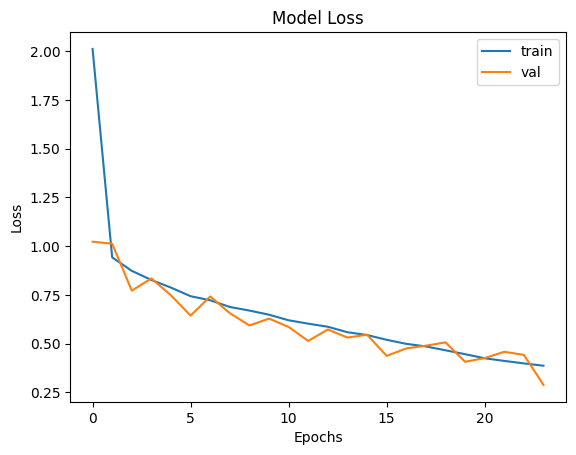

In [28]:
# Menampilkan plot loss dari model
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.show()

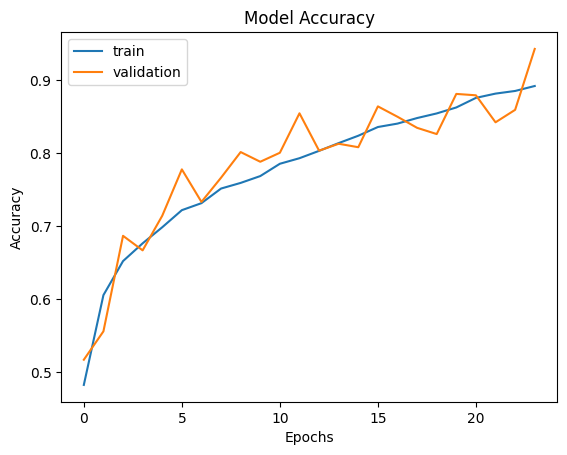

In [29]:
# Menampilkan plot akurasi dari model
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

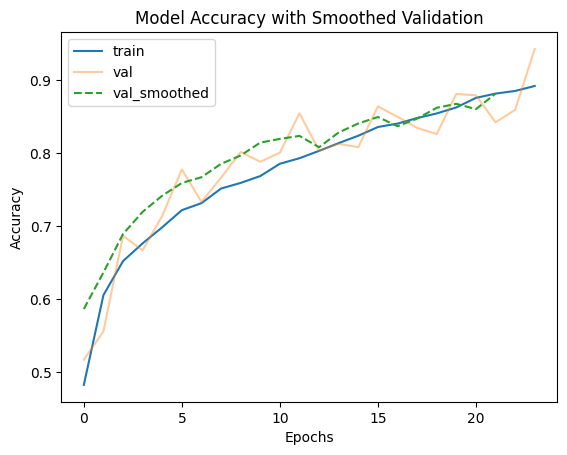

In [30]:
def moving_average(data, window_size=3):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val', alpha=0.4)
plt.plot(moving_average(history.history['val_accuracy']), label='val_smoothed', linestyle='--')
plt.title('Model Accuracy with Smoothed Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluasi Model

Evaluasi Model dengan Confusion Matrix, Precision, Recall & F1-Score

67/67 [==============================] - 5s 78ms/step


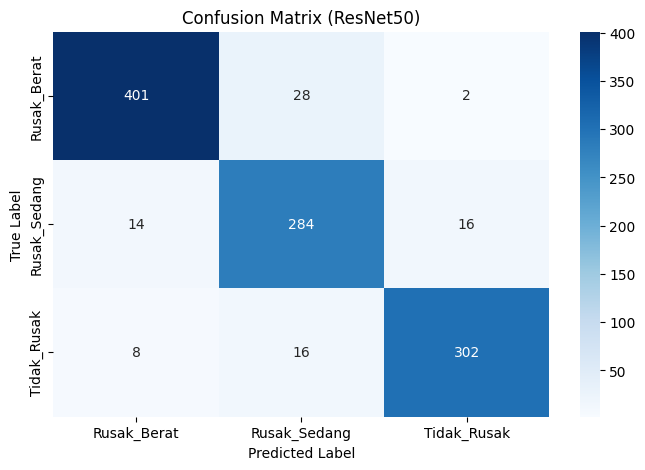

In [33]:
# Mengevaluasi model dengan confussion matrix
# Prediksi
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_labels, yticklabels=class_labels, cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (ResNet50)")
plt.show()

In [35]:
# Evaluasi model dengan precision, recall & f1-score
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

Classification Report:

              precision    recall  f1-score   support

 Rusak_Berat       0.95      0.93      0.94       431
Rusak_Sedang       0.87      0.90      0.88       314
 Tidak_Rusak       0.94      0.93      0.93       326

    accuracy                           0.92      1071
   macro avg       0.92      0.92      0.92      1071
weighted avg       0.92      0.92      0.92      1071



# ResNet 50 Model

In [37]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

In [39]:
resnet_model = Sequential([
    ResNet50(include_top=False, weights='imagenet', input_shape=(100, 100, 3)),
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])


resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.optimizers.RMSprop(learning_rate=0.0001),
                     metrics=['accuracy'])

resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_2 (Dense)             (None, 256)               524544    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 3)                 771       
                                                                 
Total params: 24,113,027
Trainable params: 24,059,907
Non-trainable params: 53,120
_____________________________________

In [40]:
callbacks = get_callbacks("resnet_bangunan_weights.h5", target_val_accuracy=0.97)

# Training ResNet Model

In [44]:
# Hitung steps per epoch otomatis
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = validation_generator.samples // validation_generator.batch_size

# Training
resnet_history = resnet_model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
535/535 [==============================] - ETA: 0s - loss: 0.3271 - accuracy: 0.8806
Epoch 1: val_accuracy improved from -inf to 0.31818, saving model to D:\Dataset Bangkit\bangkit_program\ML\saved_model\resnet_bangunan_weights.h5
535/535 [==============================] - 33s 51ms/step - loss: 0.3271 - accuracy: 0.8806 - val_loss: 14.1872 - val_accuracy: 0.3182
Epoch 2/100
535/535 [==============================] - ETA: 0s - loss: 0.1301 - accuracy: 0.9638
Epoch 2: val_accuracy improved from 0.31818 to 0.62121, saving model to D:\Dataset Bangkit\bangkit_program\ML\saved_model\resnet_bangunan_weights.h5
535/535 [==============================] - 27s 49ms/step - loss: 0.1301 - accuracy: 0.9638 - val_loss: 11.4949 - val_accuracy: 0.6212
Epoch 3/100
534/535 [============================>.] - ETA: 0s - loss: 0.0976 - accuracy: 0.9728
Epoch 3: val_accuracy improved from 0.62121 to 0.99527, saving model to D:\Dataset Bangkit\bangkit_program\ML\saved_model\resnet_bangunan_weights.

In [51]:
# Evaluation
resnet_model.evaluate(validation_generator)

67/67 [==============================] - 2s 25ms/step - loss: 0.0486 - accuracy: 0.9953


[0.04856054112315178, 0.9953314661979675]

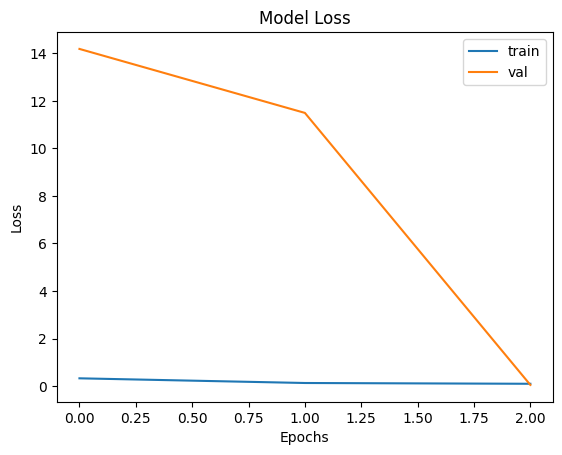

In [53]:
# Menampilkan plot loss dari model
plt.plot(resnet_history.history['loss'])
plt.plot(resnet_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.show()

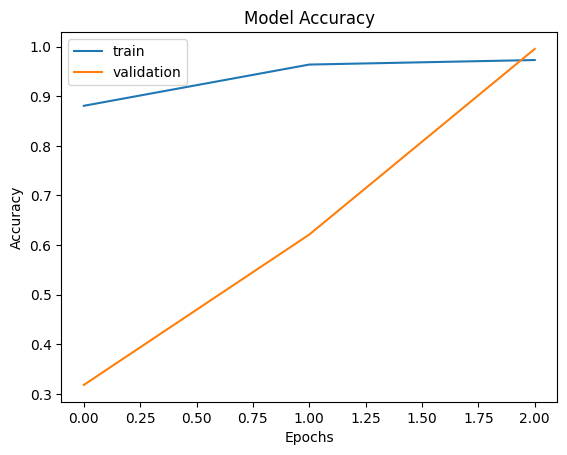

In [55]:
# Menampilkan plot akurasi dari model
plt.plot(resnet_history.history['accuracy'])
plt.plot(resnet_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

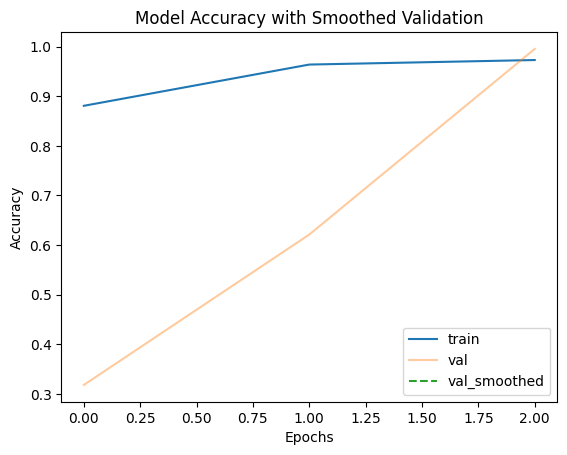

In [57]:
plt.plot(resnet_history.history['accuracy'], label='train')
plt.plot(resnet_history.history['val_accuracy'], label='val', alpha=0.4)
plt.plot(moving_average(resnet_history.history['val_accuracy']), label='val_smoothed', linestyle='--')
plt.title('Model Accuracy with Smoothed Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

67/67 [==============================] - 2s 25ms/step


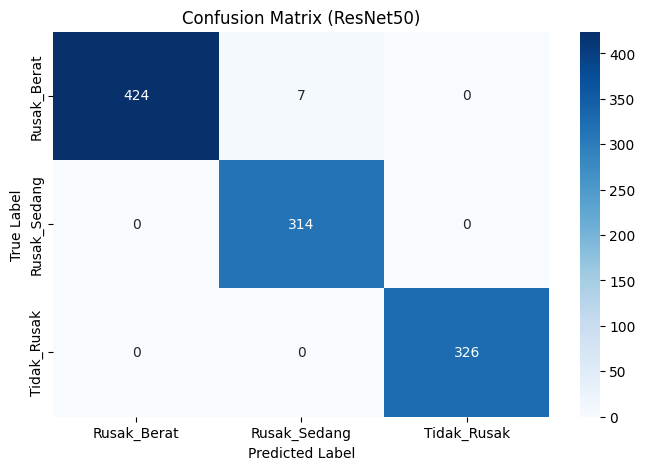

In [59]:
#Mengevaluasi model dengan confussion matrix
predictions = resnet_model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_labels, yticklabels=class_labels, cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (ResNet50)")
plt.show()

# **Prediksi Model**

In [64]:
def predict_sample_images_from_generator(model, test_generator, sample_size=9):
    # Mapping index ke label dari train_generator
    dict_label = {v: k for k, v in train_generator.class_indices.items()}
    
    # Simpan semua image & label dari seluruh generator
    all_images = []
    all_labels = []

    for i in range(len(test_generator)):
        images_batch, labels_batch = test_generator[i]
        all_images.extend(images_batch)
        all_labels.extend(labels_batch)

    all_images = np.array(all_images)
    all_labels = np.array(all_labels)
    true_labels = np.argmax(all_labels, axis=1)

    # Ambil sample acak dari seluruh data test
    indices = np.random.choice(len(all_images), size=sample_size, replace=False)
    sample_images = all_images[indices]
    sample_true_labels = true_labels[indices]

    # Prediksi
    predictions = model.predict(sample_images)
    predicted_labels = np.argmax(predictions, axis=1)

    # Plot
    cols = 3
    rows = (sample_size + cols - 1) // cols
    fig, axs = plt.subplots(rows, cols, figsize=(14, rows * 4))
    axs = axs.flatten()

    for idx in range(sample_size):
        axs[idx].imshow(sample_images[idx])
        true = dict_label[sample_true_labels[idx]]
        pred = dict_label[predicted_labels[idx]]
        axs[idx].set_title(f"True: {true}\nPredicted: {pred}", fontsize=12)
        axs[idx].axis('off')

    # Sembunyikan plot kosong kalau tidak pas
    for idx in range(sample_size, len(axs)):
        axs[idx].axis('off')

    plt.tight_layout()
    plt.show()


1/1 [==============================] - 0s 17ms/step


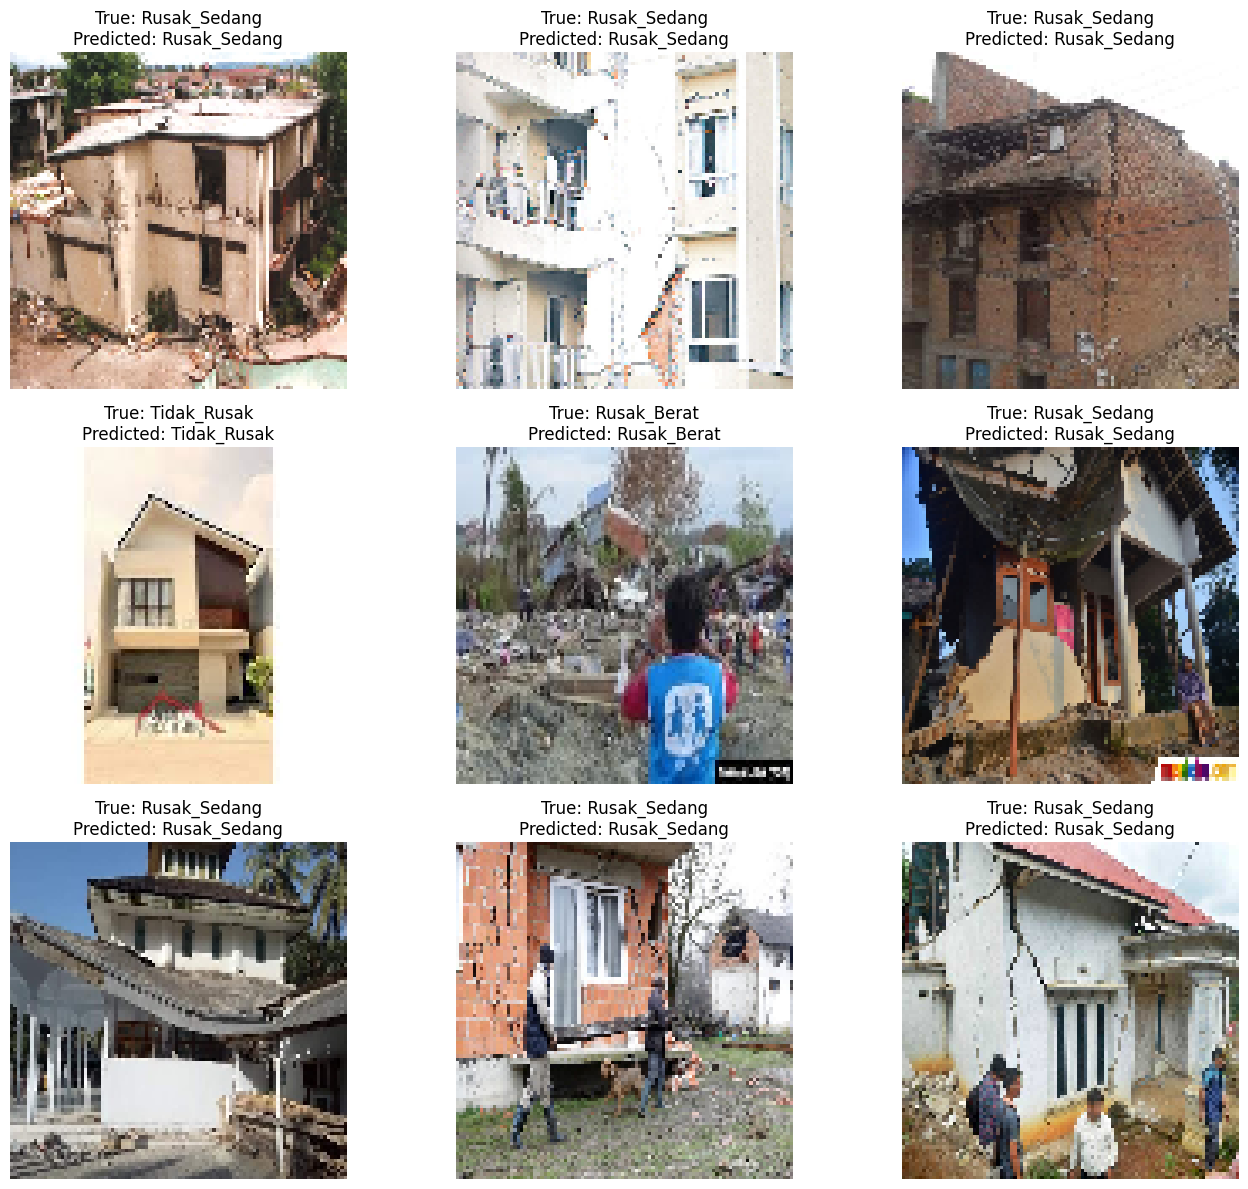

In [68]:
predict_sample_images_from_generator(resnet_model, test_generator)

In [70]:
# Mengupload dan memprediksi gambar baru yang telah diupload

def predict_uploaded_image(model, image_path, train_generator, target_size=(100, 100)):
    # Mapping index ke label dari train_generator
    dict_label = {v: k for k, v in train_generator.class_indices.items()}

    # Load dan tampilkan gambar
    img = image.load_img(image_path, target_size=target_size)
    plt.imshow(img)
    plt.axis('off')
    plt.title("Input Image")
    plt.show()

    # Preprocessing
    x = image.img_to_array(img)
    x = x / 255.0
    x = np.expand_dims(x, axis=0)

    # Prediksi
    pred = model.predict(x)
    pred_class = np.argmax(pred, axis=1)[0]
    label_name = dict_label[pred_class]

    # Hasil
    print(f"✅ Prediksi: {label_name} (class index: {pred_class})")

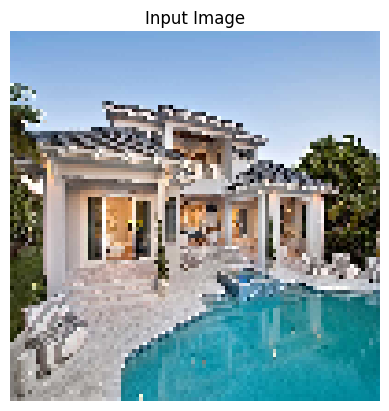

1/1 [==============================] - 0s 277ms/step
✅ Prediksi: Tidak_Rusak (class index: 2)


In [72]:
predict_uploaded_image(model, 'test_gambar/rumah_bagus.jpg', train_generator)

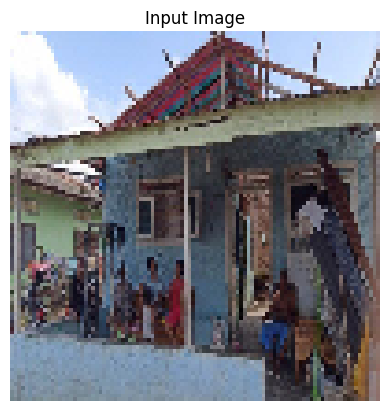

1/1 [==============================] - 0s 40ms/step
✅ Prediksi: Rusak_Sedang (class index: 1)


In [74]:
predict_uploaded_image(resnet_model, 'test_gambar/tes_rumah_sedang.jpg', train_generator)

# Komparasi Hasil CNN dan ResNet50

In [77]:
def evaluate_model(model, test_generator, model_name="Model"):
    # Ambil semua data test dari generator
    images = []
    labels = []

    for i in range(len(test_generator)):
        batch_images, batch_labels = test_generator[i]
        images.extend(batch_images)
        labels.extend(np.argmax(batch_labels, axis=1))

    images = np.array(images)
    labels = np.array(labels)

    # Prediksi
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)

    # Confusion Matrix
    cm = confusion_matrix(labels, predicted_classes)
    print(f"\n📊 Classification Report for {model_name}")
    print(classification_report(labels, predicted_classes))

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=test_generator.class_indices.keys(),
                yticklabels=test_generator.class_indices.keys())
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

    return classification_report(labels, predicted_classes, output_dict=True)

def compare_metrics(cnn_report, resnet_report, label='weighted avg'):
    metrics = ['precision', 'recall', 'f1-score']
    cnn_scores = [cnn_report[label][m] for m in metrics]
    resnet_scores = [resnet_report[label][m] for m in metrics]

    x = np.arange(len(metrics))
    width = 0.35

    plt.figure(figsize=(8, 5))
    plt.bar(x - width/2, cnn_scores, width, label='CNN')
    plt.bar(x + width/2, resnet_scores, width, label='ResNet')

    plt.xticks(x, metrics)
    plt.ylabel('Score')
    plt.title(f'Model Comparison ({label})')
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

34/34 [==============================] - 0s 4ms/step

📊 Classification Report for CNN
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       431
           1       0.87      0.90      0.88       314
           2       0.94      0.93      0.93       326

    accuracy                           0.92      1071
   macro avg       0.92      0.92      0.92      1071
weighted avg       0.92      0.92      0.92      1071



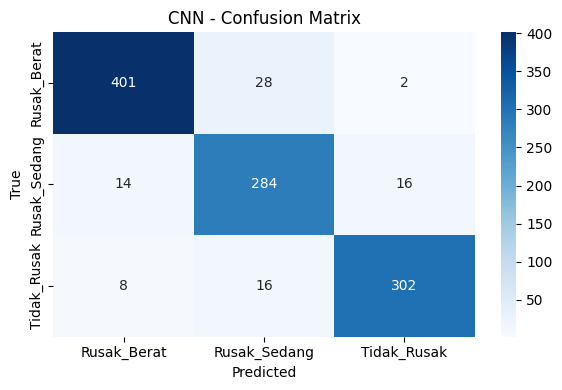

34/34 [==============================] - 0s 9ms/step

📊 Classification Report for ResNet
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       431
           1       0.98      1.00      0.99       314
           2       1.00      1.00      1.00       326

    accuracy                           0.99      1071
   macro avg       0.99      0.99      0.99      1071
weighted avg       0.99      0.99      0.99      1071



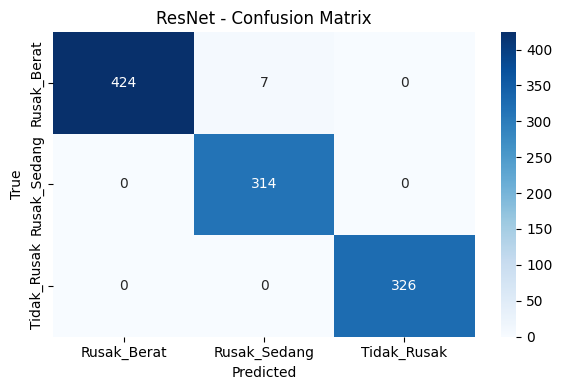

In [79]:
cnn_report = evaluate_model(model, test_generator, model_name="CNN")
resnet_report = evaluate_model(resnet_model, test_generator, model_name="ResNet")

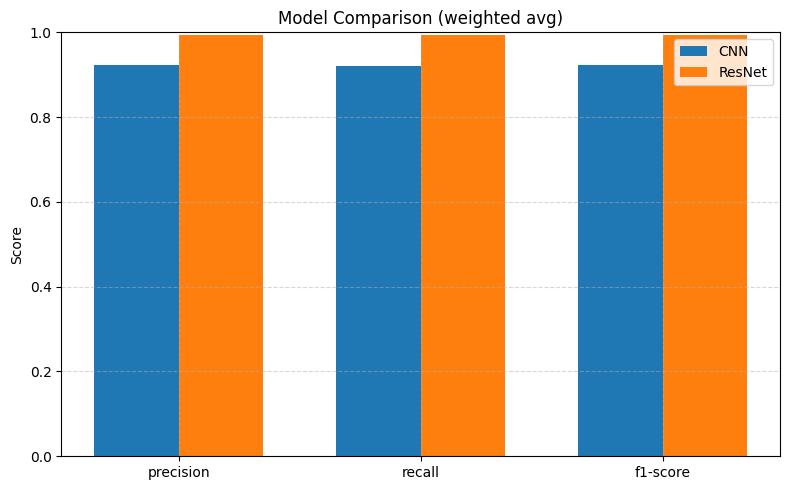

In [80]:
compare_metrics(cnn_report, resnet_report)